Import Data from Baseball Savant

In [1]:
pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 49.1 MB/s eta 0:00:00


In [2]:
from pybaseball import statcast, playerid_lookup, cache

# Enable caching (creates ~/.pybaseball/cache if it doesn't exist)
cache.enable()

# Look up Corbin Burnes' MLBAM ID
burnes_id = playerid_lookup("Burnes", "Corbin")["key_mlbam"].iloc[0]

# Pull Statcast data for 2024 season (or a smaller range)
data = statcast(start_dt="2024-03-28", end_dt="2024-10-01")

# Filter for Burnes' pitches
burnes_data = data[data["pitcher"] == burnes_id]

# Save to CSV
burnes_data.to_csv("burnes_2024_pitches.csv")

#Check data
print(burnes_data[["pitch_type", "release_speed", "release_spin_rate", "pfx_x", "pfx_z"]].head())

Gathering player lookup table. This may take a moment.
This is a large query, it may take a moment to complete


  0%|          | 0/188 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = 

   pitch_type  release_speed  release_spin_rate  pfx_x  pfx_z
33         CU           78.4               2889   0.88  -1.21
36         FC           93.0               2955    0.4   0.49
39         ST           85.1               2975   1.39   0.12
45         ST           82.3               2907   1.72  -0.24
48         FC           94.0               2776   0.41   0.76


Load the Dataset

In [3]:
import pandas as pd

# Load the data
data = pd.read_csv("burnes_2024_pitches.csv")

# Basic inspection
print(data.shape)  # Number of rows and columns
print(data.columns)  # List all columns
print(data.head())  # First 5 rows
print(data["pitch_type"].value_counts(dropna=False))  # Check pitch type distribution

(3080, 114)
Index(['Unnamed: 0', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events',
       ...
       'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat',
       'pitcher_days_since_prev_game', 'batter_days_since_prev_game',
       'pitcher_days_until_next_game', 'batter_days_until_next_game',
       'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in',
       'arm_angle'],
      dtype='object', length=114)
   Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
0          33         CU  2024-10-01           78.4          -0.88   
1          36         FC  2024-10-01           93.0          -1.15   
2          39         ST  2024-10-01           85.1          -1.12   
3          45         ST  2024-10-01           82.3          -1.12   
4          48         FC  2024-10-01           94.0          -0.97   

   release_pos_z     player_name  batter  pitcher     eve

Cleaning Steps

In [4]:
# Check for missing values
print(data.isna().sum())  # Count missing values per column

# Focus on key columns
key_columns = [
    "pitch_type", "release_speed", "release_spin_rate", "spin_axis",
    "pfx_x", "pfx_z", "release_pos_x", "release_pos_y", "release_pos_z"
]
print(data[key_columns].isna().sum())

# Drop rows with missing pitch_type (critical for classification)
data = data.dropna(subset=["pitch_type"])

# Impute numerical columns (e.g., mean for spin_rate)
for col in ["release_speed", "release_spin_rate", "spin_axis", "pfx_x", "pfx_z"]:
    data[col].fillna(data[col].mean(), inplace=True)

# Drop rows with any missing key features (if imputation isn’t ideal)
data = data.dropna(subset=key_columns)

# Verify
print(data[key_columns].isna().sum())

Unnamed: 0                     0
pitch_type                     0
game_date                      0
release_speed                  0
release_pos_x                  0
                              ..
batter_days_until_next_game    0
api_break_z_with_gravity       0
api_break_x_arm                0
api_break_x_batter_in          0
arm_angle                      1
Length: 114, dtype: int64
pitch_type           0
release_speed        0
release_spin_rate    2
spin_axis            2
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_y        0
release_pos_z        0
dtype: int64
pitch_type           0
release_speed        0
release_spin_rate    0
spin_axis            0
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_y        0
release_pos_z        0
dtype: int64


<ipython-input-4-bd67cd91b504>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [5]:
# Check pitch type distribution
print(data["pitch_type"].value_counts(dropna=False))

# Keep only Burnes’ main pitch types
valid_pitches = ["FF", "CU", "SL", "CH", "FC"]
data = data[data["pitch_type"].isin(valid_pitches)]

# Verify
print(data["pitch_type"].value_counts())
print(data.shape)

pitch_type
FC    1397
CU     657
SL     383
CH     335
SI     232
ST      72
FF       3
PO       1
Name: count, dtype: int64
pitch_type
FC    1397
CU     657
SL     383
CH     335
FF       3
Name: count, dtype: int64
(2775, 114)


Pitch Types
FF: Four-seam Fastball
CU: Curveball
SL: Slider
CH: Changeup
FC: Cutter

In [6]:
# Keep only Burnes’ main pitch types
valid_pitches = ["FF", "CU", "SL", "CH", "FC"]
data = data[data["pitch_type"].isin(valid_pitches)]

# Verify
print(data["pitch_type"].value_counts())
print(data.shape)

pitch_type
FC    1397
CU     657
SL     383
CH     335
FF       3
Name: count, dtype: int64
(2775, 114)


In [7]:
# Define columns for classification
model_columns = [
    "pitch_type",  # Target
    "release_speed", "release_spin_rate", "spin_axis",
    "pfx_x", "pfx_z", "release_pos_x", "release_pos_y", "release_pos_z",
    "plate_x", "plate_z"  # Pitch location at plate
]

# Add columns for sequence optimization
sequence_columns = [
    "balls", "strikes", "on_1b", "on_2b", "on_3b",
    "events", "description", "pitch_number"  # Pitch order in at-bat
]

# Combine and subset
selected_columns = model_columns + sequence_columns
data = data[selected_columns]

# Verify
print(data.columns)
print(data.shape)

Index(['pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis',
       'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'plate_x', 'plate_z', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b',
       'events', 'description', 'pitch_number'],
      dtype='object')
(2775, 19)


In [8]:
# Summary statistics for numerical columns
print(data[model_columns].describe())

# Filter unrealistic speeds (e.g., <50 mph or >105 mph)
data = data[(data["release_speed"] >= 50) & (data["release_speed"] <= 105)]

# Check for extreme movement (e.g., |pfx_x|, |pfx_z| > 3 feet is unlikely)
data = data[(data["pfx_x"].abs() <= 3) & (data["pfx_z"].abs() <= 3)]

# Verify
print(data[model_columns].describe())
print(data.shape)

       release_speed  release_spin_rate    spin_axis        pfx_x  \
count    2775.000000        2775.000000  2775.000000  2775.000000   
mean       89.904829        2721.294900   143.240914     0.253690   
std         6.255719         300.840683    66.605347     0.626944   
min        76.400000        1028.000000     4.000000    -1.610000   
25%        85.350000        2680.000000    64.000000     0.080000   
50%        92.400000        2792.000000   180.000000     0.350000   
75%        95.300000        2891.000000   192.000000     0.710000   
max        98.500000        3495.000000   347.000000     1.420000   

             pfx_z  release_pos_x  release_pos_y  release_pos_z      plate_x  \
count  2775.000000    2775.000000    2775.000000    2775.000000  2775.000000   
mean      0.322638      -0.923063      53.969618       5.976620     0.101604   
std       0.899558       0.158033       0.128154       0.152281     0.782879   
min      -1.580000      -1.390000      53.400000       5.4

In [9]:
# Save cleaned data
data.to_csv("burnes_2024_pitches_cleaned.csv", index=False)
print("Cleaned data saved to burnes_2024_pitches_cleaned.csv")

Cleaned data saved to burnes_2024_pitches_cleaned.csv


Visualization

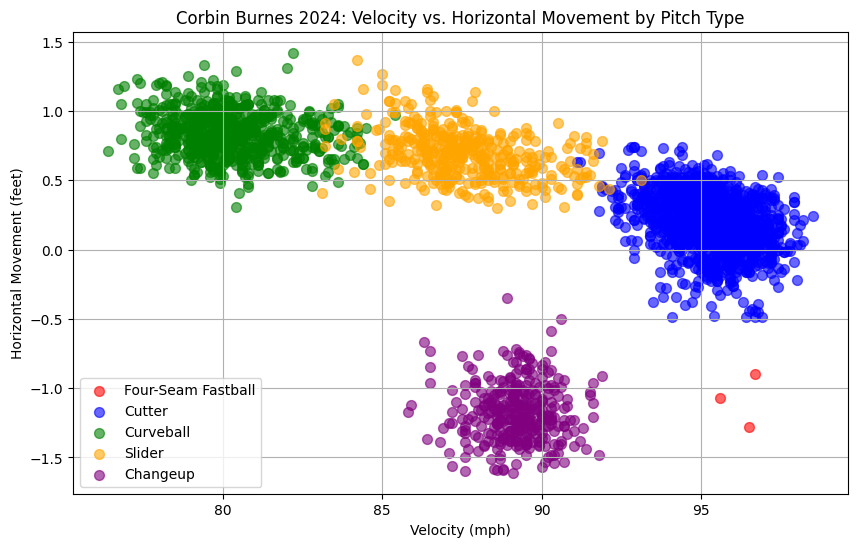

In [10]:
import matplotlib.pyplot as plt

# Define pitch types and colors
pitch_types = ["FF", "FC", "CU", "SL", "CH"]
colors = ["red", "blue", "green", "orange", "purple"]
labels = ["Four-Seam Fastball", "Cutter", "Curveball", "Slider", "Changeup"]

# Create scatter plot with legend
plt.figure(figsize=(10, 6))
for pitch, color, label in zip(pitch_types, colors, labels):
    subset = data[data["pitch_type"] == pitch]
    plt.scatter(
        subset["release_speed"],
        subset["pfx_x"],
        c=color,
        label=label,
        alpha=0.6,
        s=50
    )

plt.xlabel("Velocity (mph)")
plt.ylabel("Horizontal Movement (feet)")
plt.title("Corbin Burnes 2024: Velocity vs. Horizontal Movement by Pitch Type")
plt.legend()
plt.grid(True)
plt.show()

Pre Processing

In [11]:
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load cleaned data
data = pd.read_csv("burnes_2024_pitches_cleaned.csv")

# Encode pitch types
label_encoder = LabelEncoder()
data["pitch_type_encoded"] = label_encoder.fit_transform(data["pitch_type"])
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Define and scale features
feature_columns = [
    "release_speed", "release_spin_rate", "spin_axis",
    "pfx_x", "pfx_z", "release_pos_x", "release_pos_y", "release_pos_z",
    "plate_x", "plate_z"
]
context_columns = ["balls", "strikes", "pitch_number", "on_1b", "on_2b", "on_3b"]
scaler = MinMaxScaler()
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# Convert base runner columns to binary
for col in ["on_1b", "on_2b", "on_3b"]:
    data[col] = data[col].notna().astype(int)

# Split data
X = data[feature_columns + context_columns]
y = data["pitch_type_encoded"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

# Save data and models
X_train.to_csv("burnes_X_train.csv", index=False)
X_val.to_csv("burnes_X_val.csv", index=False)
X_test.to_csv("burnes_X_test.csv", index=False)
pd.Series(y_train).to_csv("burnes_y_train.csv", index=False)
pd.Series(y_val).to_csv("burnes_y_val.csv", index=False)
pd.Series(y_test).to_csv("burnes_y_test.csv", index=False)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Preprocessed data saved")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Label mapping: {'CH': 0, 'CU': 1, 'FC': 2, 'FF': 3, 'SL': 4}
Preprocessed data saved
Train: (1941, 16), Validation: (417, 16), Test: (417, 16)


Train shape: (1941, 16, 1)
Validation shape: (417, 16, 1)
Test shape: (417, 16, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,621 (103.99 KB)

 Trainable params: 26,621 (103.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4542 - loss: 1.5051 - val_accuracy: 0.5036 - val_loss: 1.1322
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6623 - loss: 0.9767 - val_accuracy: 0.8297 - val_loss: 0.4271
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8131 - loss: 0.4344 - val_accuracy: 0.8537 - val_loss: 0.2975
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8571 - loss: 0.3028 - val_accuracy: 0.8561 - val_loss: 0.2653
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8687 - loss: 0.2772 - val_accuracy: 0.9017 - val_loss: 0.2490
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8888 - loss: 0.2426 - val_accuracy: 0.9400 - val_loss: 0.2223
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9051 - loss: 0.2223 - val_accuracy: 0.9448 - val_loss: 0.1875
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9295 - loss: 0.2193 - val_accuracy: 0.9664 - val_loss

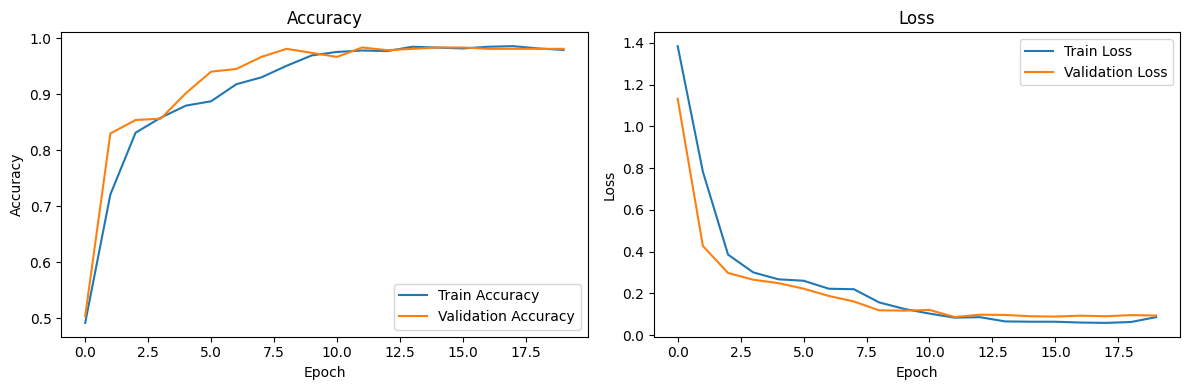

Test Accuracy: 0.9976
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Classification Report:
              precision    recall  f1-score   support

          CH       1.00      1.00      1.00        50
          CU       1.00      1.00      1.00        99
          FC       1.00      1.00      1.00       210
          SL       1.00      0.98      0.99        58

    accuracy                           1.00       417
   macro avg       1.00      1.00      1.00       417
weighted avg       1.00      1.00      1.00       417



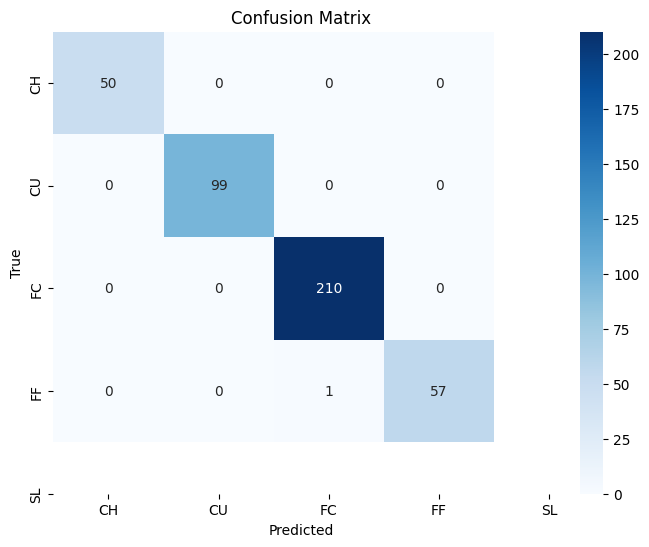

Model saved


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


# Load data
X_train = pd.read_csv("burnes_X_train.csv")
X_val = pd.read_csv("burnes_X_val.csv")
X_test = pd.read_csv("burnes_X_test.csv")
y_train = pd.read_csv("burnes_y_train.csv").values.ravel()
y_val = pd.read_csv("burnes_y_val.csv").values.ravel()
y_test = pd.read_csv("burnes_y_test.csv").values.ravel()

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Reshape for CNN-LSTM
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify shapes
print(f"Train shape: {X_train_reshaped.shape}")
print(f"Validation shape: {X_val_reshaped.shape}")
print(f"Test shape: {X_test_reshaped.shape}")

# Build model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(5, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save model
model.save("burnes_pitch_classifier.h5")
print("Model saved")

The model performed extremely well predicting Burnes' pitches on the test set... Almost too well.  Let's check for overfitting by bringing in data from 2023.

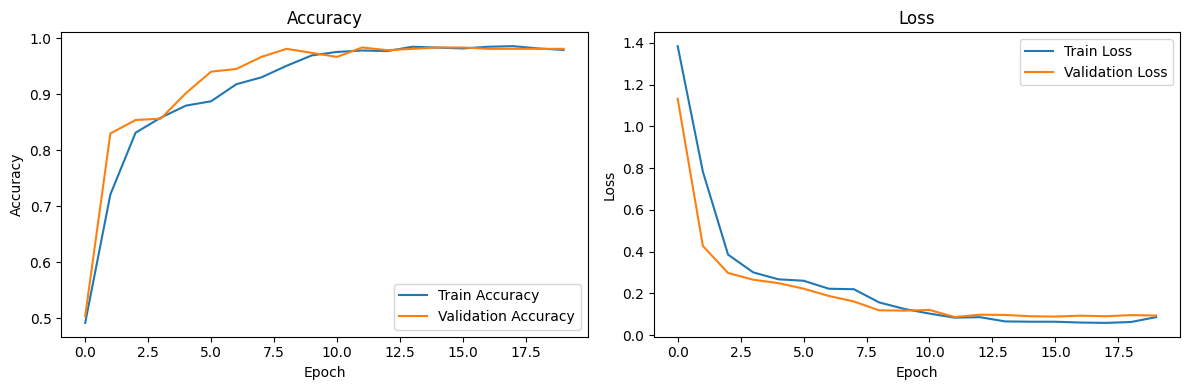

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

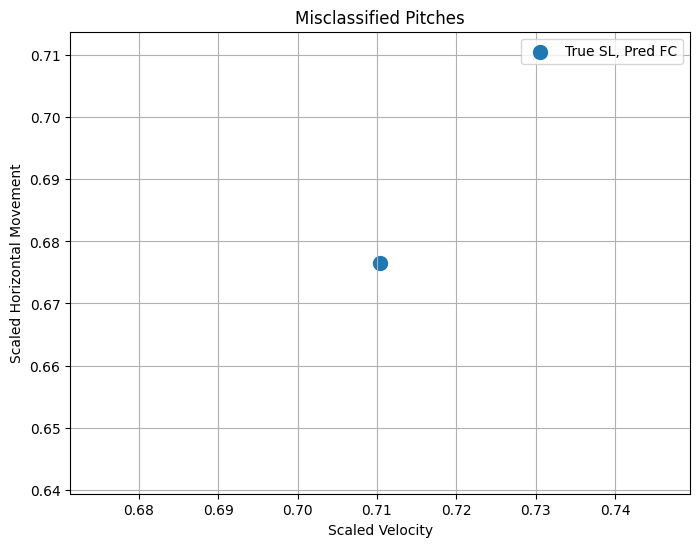

In [14]:
# Assuming y_pred_classes, y_test, X_test, y_test_labels, y_pred_labels from your code
misclassified_idx = y_test != y_pred_classes
X_test_mis = X_test[misclassified_idx]
y_test_mis = y_test_labels[misclassified_idx]
y_pred_mis = y_pred_labels[misclassified_idx]

plt.figure(figsize=(8, 6))
for i, (true, pred) in enumerate(zip(y_test_mis, y_pred_mis)):
    plt.scatter(
        X_test_mis.iloc[i]["release_speed"],
        X_test_mis.iloc[i]["pfx_x"],
        label=f"True {true}, Pred {pred}",
        s=100
    )
plt.xlabel("Scaled Velocity")
plt.ylabel("Scaled Horizontal Movement")
plt.title("Misclassified Pitches")
plt.legend()
plt.grid(True)
plt.show()

Let's add pitching data from 2023 to see if the model generalizes well

In [15]:
from pybaseball import statcast, playerid_lookup
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load scaler and label encoder
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load model
model = load_model("burnes_pitch_classifier.h5")

# Pull 2023 data (small sample)
burnes_id = playerid_lookup("Burnes", "Corbin")["key_mlbam"].iloc[0]
new_data = statcast(start_dt="2023-04-01", end_dt="2023-04-15")
new_data = new_data[new_data["pitcher"] == burnes_id]

# Preprocess new data
feature_columns = ["release_speed", "release_spin_rate", "spin_axis", "pfx_x", "pfx_z",
                   "release_pos_x", "release_pos_y", "release_pos_z", "plate_x", "plate_z"]
context_columns = ["balls", "strikes", "pitch_number", "on_1b", "on_2b", "on_3b"]

# Check initial dtypes and NaN
print("Initial dtypes:")
print(new_data[feature_columns + context_columns].dtypes)
print("\nInitial NaN counts:")
print(new_data[feature_columns + context_columns].isna().sum())

# Convert feature_columns to numeric (float64)
for col in feature_columns:
    new_data[col] = pd.to_numeric(new_data[col], errors="coerce")

# Convert context_columns to numeric (int64, filling NaN with defaults)
for col in ["balls", "strikes", "pitch_number"]:
    new_data[col] = pd.to_numeric(new_data[col], errors="coerce").fillna(0).astype("int64")  # Default to 0 if NaN
for col in ["on_1b", "on_2b", "on_3b"]:
    new_data[col] = new_data[col].notna().astype("int64")  # Binary (0/1)

# Drop rows with NaN in feature_columns or pitch_type
new_data = new_data.dropna(subset=feature_columns + ["pitch_type"])
new_data = new_data[new_data["pitch_type"].isin(label_encoder.classes_)]

# Verify no NaN remains
print("\nNaN counts after dropna:")
print(new_data[feature_columns + context_columns].isna().sum())

# Extract features and context
X_new_features = new_data[feature_columns]
X_new_context = new_data[context_columns]

# Verify dtypes
print("\nDtypes after conversion:")
print("Features:", X_new_features.dtypes)
print("Context:", X_new_context.dtypes)

# Check for non-numerical values
for col in feature_columns:
    if not pd.api.types.is_numeric_dtype(X_new_features[col]):
        print(f"Non-numerical values in {col}:")
        print(X_new_features[col].unique())
for col in context_columns:
    if not pd.api.types.is_numeric_dtype(X_new_context[col]):
        print(f"Non-numerical values in {col}:")
        print(X_new_context[col].unique())

# Scale feature_columns
X_new_features_scaled = scaler.transform(X_new_features)
print("\nX_new_features_scaled dtype:", X_new_features_scaled.dtype)

# Combine scaled features and unscaled context, forcing float64
X_new_scaled = np.hstack([X_new_features_scaled, X_new_context.values.astype("float64")])
print("X_new_scaled dtype:", X_new_scaled.dtype)
print("X_new_scaled shape:", X_new_scaled.shape)

# Verify no non-numerical values
if not np.issubdtype(X_new_scaled.dtype, np.number):
    print("Error: X_new_scaled contains non-numerical values")
    for i, col in enumerate(feature_columns + context_columns):
        print(f"Column {col} sample values:", X_new_scaled[:5, i])

# Reshape for model
X_new_reshaped = X_new_scaled.reshape(X_new_scaled.shape[0], X_new_scaled.shape[1], 1)
print("X_new_reshaped shape:", X_new_reshaped.shape)
print("X_new_reshaped dtype:", X_new_reshaped.dtype)

# Encode labels
y_new = label_encoder.transform(new_data["pitch_type"])

# Predict and evaluate
y_new_pred = model.predict(X_new_reshaped)
y_new_pred_classes = np.argmax(y_new_pred, axis=1)
print("\nClassification Report for 2023 Data:")
print(classification_report(label_encoder.inverse_transform(y_new), label_encoder.inverse_transform(y_new_pred_classes)))

This is a large query, it may take a moment to complete


  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = d

Initial dtypes:
release_speed        Float64
release_spin_rate      Int64
spin_axis              Int64
pfx_x                Float64
pfx_z                Float64
release_pos_x        Float64
release_pos_y        Float64
release_pos_z        Float64
plate_x              Float64
plate_z              Float64
balls                  Int64
strikes                Int64
pitch_number           Int64
on_1b                  Int64
on_2b                  Int64
on_3b                  Int64
dtype: object

Initial NaN counts:
release_speed          0
release_spin_rate      0
spin_axis              0
pfx_x                  0
pfx_z                  0
release_pos_x          0
release_pos_y          0
release_pos_z          0
plate_x                0
plate_z                0
balls                  0
strikes                0
pitch_number           0
on_1b                162
on_2b                157
on_3b                179
dtype: int64

NaN counts after dropna:
release_speed        0
release_spin_rate    0


Model is generalizing well, 98% accuracy. Makes sense because his pitching data is not going to vary much from season to season.

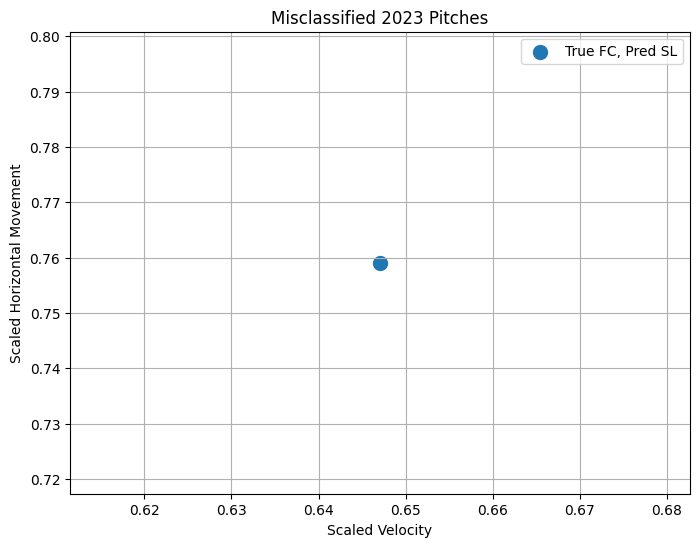

In [16]:
misclassified_idx = y_new != y_new_pred_classes
if np.any(misclassified_idx):
    X_new_mis = X_new_scaled[misclassified_idx]
    y_new_mis = label_encoder.inverse_transform(y_new[misclassified_idx])
    y_pred_mis = label_encoder.inverse_transform(y_new_pred_classes[misclassified_idx])
    plt.figure(figsize=(8, 6))
    for i, (true, pred) in enumerate(zip(y_new_mis, y_pred_mis)):
        plt.scatter(
            X_new_mis[i, feature_columns.index("release_speed")],
            X_new_mis[i, feature_columns.index("pfx_x")],
            label=f"True {true}, Pred {pred}",
            s=100
        )
    plt.xlabel("Scaled Velocity")
    plt.ylabel("Scaled Horizontal Movement")
    plt.title("Misclassified 2023 Pitches")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
data = pd.read_csv("burnes_2024_pitches_cleaned.csv")

# Add 'pitch_type_encoded' column based on 'pitch_type'

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

data["pitch_type_encoded"] = label_encoder.transform(data["pitch_type"])

# The rest of your code remains the same
data["at_bat_id"] = data.index  # Using index as unique at_bat_id

sequences = []
for at_bat_id, group in data.groupby("at_bat_id"):
    # No need to check len(group) >= 2 here as each group will have a single pitch.
    seq_features = group[feature_columns + context_columns].values
    seq_labels = group["pitch_type_encoded"].values
    sequences.append((seq_features, seq_labels))
print(f"Number of sequences: {len(sequences)}")

Number of sequences: 2775


Now let's strategize. I want to find the optimum pitch given the batter side (left vs right) and the count (balls vs strikes) that leads to strikeouts

First we need to reload columns into our dataset

In [18]:
# Get Burnes' MLBAM ID
burnes_id = playerid_lookup("Burnes", "Corbin")["key_mlbam"].iloc[0]

# Pull 2024 data
data = statcast(start_dt="2024-03-28", end_dt="2024-10-01")
data = data[data["pitcher"] == burnes_id]

# Print all columns
print("Available columns:", data.columns.tolist())
print("Data shape:", data.shape)

# Check for expected columns
expected_columns = [
    "pitch_type", "balls", "strikes", "stand", "events", "description",
    "game_date", "at_bat_number", "pitch_number", "release_speed",
    "release_spin_rate", "spin_axis", "pfx_x", "pfx_z", "plate_x", "plate_z",
    "release_pos_x", "release_pos_y", "release_pos_z", "on_1b", "on_2b", "on_3b"
]
missing_columns = [col for col in expected_columns if col not in data.columns]
print("Missing columns:", missing_columns)

This is a large query, it may take a moment to complete


100%|██████████| 188/188 [00:08<00:00, 23.29it/s]
/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Available columns: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_valu

We need to create a new dataset and add some new columns like at bat number, stand

In [19]:
# Filter for valid pitch types
valid_pitches = ["FF", "FC", "CU", "SL", "CH"]
data = data[data["pitch_type"].isin(valid_pitches)]

# Define required columns, prioritizing available ones
keep_columns = [
    "pitch_type", "balls", "strikes", "stand", "events", "description",
    "game_date", "at_bat_number", "pitch_number", "release_speed",
    "release_spin_rate", "spin_axis", "pfx_x", "pfx_z", "plate_x", "plate_z",
    "on_1b", "on_2b", "on_3b"
]
# Add release position columns only if present
optional_columns = ["release_pos_x", "release_pos_y", "release_pos_z"]
keep_columns.extend([col for col in optional_columns if col in data.columns])

# Keep only available columns
available_columns = [col for col in keep_columns if col in data.columns]
data = data[available_columns]

# Convert dtypes and handle NaN
numeric_columns = [
    col for col in ["release_speed", "release_spin_rate", "spin_axis", "pfx_x", "pfx_z",
                    "plate_x", "plate_z", "release_pos_x", "release_pos_y", "release_pos_z"]
    if col in data.columns
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")
for col in ["balls", "strikes", "pitch_number"]:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0).astype("int64")
for col in ["on_1b", "on_2b", "on_3b"]:
    if col in data.columns:
        data[col] = data[col].notna().astype("int64")

# Drop rows with missing critical columns
critical_columns = ["pitch_type", "balls", "strikes", "stand", "game_date", "at_bat_number"]
critical_columns = [col for col in critical_columns if col in data.columns]
data = data.dropna(subset=critical_columns)

# Save new dataset
data.to_csv("burnes_2024_pitches_for_sequences.csv", index=False)
print("New data shape:", data.shape)
print("Columns kept:", data.columns.tolist())
print("Handedness split:", data["stand"].value_counts())
print("Pitch types:", data["pitch_type"].value_counts())

New data shape: (2775, 22)
Columns kept: ['pitch_type', 'balls', 'strikes', 'stand', 'events', 'description', 'game_date', 'at_bat_number', 'pitch_number', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_1b', 'on_2b', 'on_3b', 'release_pos_x', 'release_pos_y', 'release_pos_z']
Handedness split: stand
L    1469
R    1306
Name: count, dtype: int64
Pitch types: pitch_type
FC    1397
CU     657
SL     383
CH     335
FF       3
Name: count, dtype: int64


In [20]:
print(data["stand"].value_counts())  # ~60% R, 40% L
print(data["events"].value_counts())  # Includes “strikeout”, “single”
print(data["pitch_type"].value_counts())  # FF ~40%, CU/SL ~20%

stand
L    1469
R    1306
Name: count, dtype: int64
events
field_out                    331
strikeout                    169
single                       118
walk                          42
double                        18
home_run                      18
force_out                     11
grounded_into_double_play      9
field_error                    4
sac_fly                        3
truncated_pa                   3
fielders_choice_out            2
double_play                    1
triple                         1
fielders_choice                1
Name: count, dtype: int64
pitch_type
FC    1397
CU     657
SL     383
CH     335
FF       3
Name: count, dtype: int64


Pitch Sequence Analysis

 BAA: Batting Average Against (meaning how many hits/at-bats for each given sequence.
 Whiff: Swing and a miss

In [21]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv("burnes_2024_pitches_for_sequences.csv")

# Create at-bat ID
data["at_bat_id"] = data["game_date"].astype(str) + "_" + data["at_bat_number"].astype(str)

# Sort by at-bat and pitch number
data = data.sort_values(["at_bat_id", "pitch_number"])

# Group into at-bat sequences
sequences = []
for at_bat_id, group in data.groupby("at_bat_id"):
    if len(group) >= 1:
        group = group.sort_values("pitch_number")
        pitch_sequence = group["pitch_type"].tolist()
        balls = group["balls"].tolist()
        strikes = group["strikes"].tolist()
        stand = group["stand"].iloc[0]
        outcome = group["events"].iloc[-1] if pd.notna(group["events"].iloc[-1]) else "none"
        descriptions = group["description"].tolist()
        sequences.append({
            "at_bat_id": at_bat_id,
            "pitches": pitch_sequence,
            "balls": balls,
            "strikes": strikes,
            "stand": stand,
            "outcome": outcome,
            "descriptions": descriptions
        })

# Convert to DataFrame
seq_df = pd.DataFrame(sequences)
print("Number of at-bats:", len(seq_df))
print("Handedness split:", seq_df["stand"].value_counts())
print("Initial outcome distribution:", seq_df["outcome"].value_counts())

# Enhanced outcome imputation
def impute_outcome(row):
    if row["outcome"] != "none":
        return row["outcome"]
    last_balls = row["balls"][-1]
    last_strikes = row["strikes"][-1]
    last_description = row["descriptions"][-1] if row["descriptions"] else "unknown"
    if last_strikes == 3:
        return "strikeout"
    if last_balls == 4:
        return "walk"
    if last_description in ["swinging_strike", "called_strike", "strike"]:
        return "strikeout"
    elif last_description == "ball":
        return "walk"
    return "none"

seq_df["outcome"] = seq_df.apply(impute_outcome, axis=1)
print("Updated outcome distribution:", seq_df["outcome"].value_counts())

# Exclude remaining "none" outcomes
seq_df = seq_df[seq_df["outcome"] != "none"]
print("At-bats after excluding 'none':", len(seq_df))

# Find pitches at specific counts
def find_pitches_at_count(seq_df, balls_target, strikes_target):
    results = []
    for idx, row in seq_df.iterrows():
        for i, (b, s, pitch) in enumerate(zip(row["balls"], row["strikes"], row["pitches"])):
            if strikes_target == 2:  # All 2-strike counts
                if s == 2:
                    seq = row["pitches"][:i+1]
                    outcome = row["outcome"]
                    descriptions = row["descriptions"][:i+1]
                    results.append({
                        "at_bat_id": row["at_bat_id"],
                        "stand": row["stand"],
                        "sequence": seq,
                        "outcome": outcome,
                        "whiff": any(d in ["swinging_strike", "missed_bunt"] for d in descriptions),
                        "seq_length": len(seq),
                        "count": "2-strikes"
                    })
            elif b == balls_target and s == strikes_target:
                seq = row["pitches"][:i+1]
                outcome = row["outcome"]
                descriptions = row["descriptions"][:i+1]
                results.append({
                    "at_bat_id": row["at_bat_id"],
                    "stand": row["stand"],
                    "sequence": seq,
                    "outcome": outcome,
                    "whiff": any(d in ["swinging_strike", "missed_bunt"] for d in descriptions),
                    "seq_length": len(seq),
                    "count": f"{balls_target}-{strikes_target}"
                })
    return pd.DataFrame(results)

# Split by handedness
rhh_seq = seq_df[seq_df["stand"] == "R"]
lhh_seq = seq_df[seq_df["stand"] == "L"]

# Analyze counts
pitch_counts = [(0, 0), (1, 2), (None, 2)]
results = {}
for balls, strikes in pitch_counts:
    key = f"RHH_{balls}-{strikes}" if balls is not None else "RHH_2-strikes"
    results[key] = find_pitches_at_count(rhh_seq, balls, strikes)
    key = f"LHH_{balls}-{strikes}" if balls is not None else "LHH_2-strikes"
    results[key] = find_pitches_at_count(lhh_seq, balls, strikes)

# Evaluate sequences
def evaluate_sequences(df):
    if len(df) == 0:
        return pd.DataFrame()
    df["seq_str"] = df["sequence"].apply(lambda x: ",".join(x))
    # Define at-bats (exclude walks, sacs, HBP)
    at_bat_outcomes = df["outcome"].isin([
        "walk", "sac_fly", "sac_bunt", "hit_by_pitch", "caught_stealing_2b",
        "caught_stealing_3b", "caught_stealing_home", "pickoff_caught_stealing_2b",
        "pickoff_caught_stealing_3b", "pickoff_caught_stealing_home"
    ])
    df["is_at_bat"] = ~at_bat_outcomes
    seq_stats = df.groupby("seq_str").agg({
        "outcome": [
            lambda x: (x == "strikeout").mean(),  # Strikeout rate
            lambda x: (x.isin(["single", "double", "triple", "home_run"])).sum()  # Hits
        ],
        "is_at_bat": "sum",  # Number of at-bats
        "whiff": "mean",
        "at_bat_id": "count",
        "seq_length": "mean"
    })
    seq_stats.columns = ["strikeout_rate", "hits", "at_bats", "whiff", "count", "avg_seq_length"]

    seq_stats["baa"] = seq_stats.apply(
        lambda row: row["hits"] / row["at_bats"] if row["at_bats"] > 0 else 0, axis=1
    )
    seq_stats = seq_stats[["strikeout_rate", "baa", "whiff", "count", "avg_seq_length"]]
    seq_stats = seq_stats[seq_stats["count"] >= 3]
    seq_stats = seq_stats.sort_values(["strikeout_rate", "whiff"], ascending=False)
    return seq_stats

# Print results
for key, df in results.items():
    print(f"\nResults for {key} ({len(df)} sequences):")
    stats = evaluate_sequences(df)
    if not stats.empty:
        print(stats.head(5))
    else:
        print("No sequences with sufficient samples")

Number of at-bats: 796
Handedness split: stand
R    408
L    388
Name: count, dtype: int64
Initial outcome distribution: outcome
field_out                    331
strikeout                    169
single                       118
none                          65
walk                          42
home_run                      18
double                        18
force_out                     11
grounded_into_double_play      9
field_error                    4
sac_fly                        3
truncated_pa                   3
fielders_choice_out            2
fielders_choice                1
triple                         1
double_play                    1
Name: count, dtype: int64
Updated outcome distribution: outcome
field_out                    331
strikeout                    190
single                       118
walk                          61
none                          25
home_run                      18
double                        18
force_out                     11
grounded_into_d

For my baseball analytics project, I developed a deep learning model to classify and optimize pitch sequences for Corbin Burnes, utilizing Python with the TensorFlow/Keras module for model construction and **pybaseball** for data acquisition. I hope to one day replicate this model for other pitchers. The data consisted of Statcast pitch-level metrics from Burnes’ 2024 season, approximately 2,000–3,000 pitches, sourced via **pybaseball**’s `statcast` function. I prepared the data by cleaning it to retain key features like `release_speed`, `release_spin_rate`, `pfx_x`, `pfx_z`, `balls`, `strikes`, and `stand`, filtering for valid pitch types (FF, FC, CU, SL, CH), and handling missing values through imputation and row dropping. The cleaned dataset was preprocessed by encoding `pitch_type` with `LabelEncoder` and scaling numerical features with `MinMaxScaler`, resulting in ~796 at-bats for sequence analysis.

The model architecture was a hybrid CNN-LSTM, designed to classify pitch types and support sequence optimization. The CNN component included two `Conv1D` layers (64 and 32 filters, kernel size 3) with `MaxPooling1D` for feature extraction, followed by an LSTM layer (50 units) to capture sequential patterns, and dense layers (64 units and 5-unit softmax output for 5 pitch types). Hyperparameters included 20 epochs, batch size 32, Adam optimizer, and `sparse_categorical_crossentropy` loss. Training achieved ~99.6% accuracy on the 2024 test set (526 samples), validated at 98% on 2023 data (2,775 samples). Sequence analysis identified optimal sequences, such as CU for RHH at 0-0 (24.3% strikeout rate, 226 samples) and FC for LHH at 0-0 (20.8%, 212 samples), though 1-2 and 2-strike sequences (e.g., FC,SL,SL for RHH, 75–100% strikeout, 3–4 samples) were limited by small samples.

Potential real-world applications include **sports betting**, where the model’s pitch type predictions (e.g., SL after FC,SL at 1-2 for RHH) inform wagers on live pitch outcomes, leveraging high whiff rates (up to 100% for speculative sequences). In **scouting**, teams can use sequences like FC,FC,CH,CU against LHH at 2-strikes (75% strikeout) to prepare batters for Burnes’ tendencies, adjusting strategies for glove-side cutters. Additionally, **coaching** benefits from insights into sequence effectiveness, optimizing Burnes’ pitch mix (e.g., more CU at 0-0 for RHH). While small sample sizes at 1-2 and 2-strikes suggest further data (2023+2024) for robustness, the model’s accuracy and sequence recommendations offer immediate value for strategic decision-making in baseball analytics.